# Zona incerta region (ZIR) intersubject structural connectivity comparison

## Python libraries

In [0]:
from __future__ import annotations

import itertools as it
import os
import subprocess
from copy import deepcopy
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import polars as pl
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

## Constants

_Note: These should be updated to reflect paths saved on user-specific machines._

In [ ]:
USER = "tkai"

# Directories
GRAHAM_DIR = Path(f"/home/ROBARTS/{USER}/graham")
RESOURCES_DIR = Path(f"{os.getcwd()}/resources")
ZONACONN_DIR = Path(os.getcwd()).parent
LOCAL_DIR = Path(f"/localscratch/{USER}")

# Constants
SUBSETS = ["test", "retest", "7t", "3t"]
GROUP = "MNI152NLin6Asym"
TEMPLATE_FPATH = {
    "test": {
        "l": "../zonaconn-smk_testretest/hcp_test/results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-L_label-ZIR_desc-sorted_from-group_method-spectralcosine_k-6_dseg.nii.gz",
        "r": "../zonaconn-smk_testretest/hcp_test/results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-R_label-ZIR_desc-sorted_from-group_method-spectralcosine_k-6_dseg.nii.gz",
    },
    "retest": {
        "l": "../zonaconn-smk_testretest/hcp_retest/results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-L_label-ZIR_desc-sorted_from-group_method-spectralcosine_k-6_dseg.nii.gz",
        "r": "../zonaconn-smk_testretest/hcp_retest/results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-R_label-ZIR_desc-sorted_from-group_method-spectralcosine_k-6_dseg.nii.gz",
    },
    "7t": {
        "l": "../zonaconn-smk_7T/results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-L_label-ZIR_desc-sorted_from-group_method-spectralcosine_k-6_dseg.nii.gz",
        "r": "../zonaconn-smk_7T/results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-R_label-ZIR_desc-sorted_from-group_method-spectralcosine_k-6_dseg.nii.gz",
    },
    "3t": {
        "l": "../zonaconn-smk_3T/results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-L_label-ZIR_desc-sorted_from-group_method-spectralcosine_k-6_dseg.nii.gz",
        "r": "../zonaconn-smk_3T/results/diffparc/tpl-MNI152NLin6Asym/tpl-MNI152NLin6Asym_hemi-R_label-ZIR_desc-sorted_from-group_method-spectralcosine_k-6_dseg.nii.gz",
    },
}

# Containers
ANTS_CONTAINER = GRAHAM_DIR.joinpath(
    "singularity/bids-apps/khanlab_neuroglia-core_latest.sif"
)

## Methods / Functions

### Checks

In [ ]:
# Conditional checks


def _check_subset(subset: str) -> None:
    """Utility method to check if provided subset is valid

    Parameters
    ----------
    subset
        String value indicating subset

    Raises
    ------
    ValueError
        If subset is not one of ["3T", "7T", "Test", "Retest"]
    """

    if subset.lower() not in SUBSETS:
        raise ValueError("Invalid subset")

In [ ]:
def _check_hemi(hemi: str) -> None:
    """Utility method to check if provided hemisphere is valid

    Parameters
    ----------
    hemi
        String value indicating subset

    Returns
    -------
    ValueError
        If hemisphere does not indicate one of left or right
    """

    if hemi.lower() not in ["l", "r"]:
        raise ValueError("Invalid hemisphere")

### Helpers

In [ ]:
def _update_subject(subject: str) -> str:
    """Helper function to preprend 'sub-' to subject id

    Parameters
    ----------
    subject
        Participant id to prepend to

    Returns
    -------
    str
        Subject with 'sub-' prepended (e.g. 001 -> sub-001)
    """

    if subject.startswith("sub-"):
        return subject

    return f"sub-{subject}"

In [ ]:
def get_data_dir(subset: str) -> os.PathLike:
    """Get subset associated results directory

    Parameters
    ----------
    subset
        Subset to get associated results directory for

    Returns
    -------
    os.PathLike
        Path to results directory

    Raises
    ------
    ValueError
        If subset is invalid
    """

    _check_subset(subset)

    subset_mapping = {
        "test": "zonaconn-smk_testretest/hcp_test/results",
        "retest": "zonaconn-smk_testretest/hcp_retest/results",
        "3t": "zonaconn-smk_3T/results",
        "7t": "zonaconn-smk_7T/results",
    }

    return Path(ZONACONN_DIR).joinpath(subset_mapping[subset.lower()])

In [ ]:
def get_subject_list(subset: str) -> pl.DataFrame:
    """Get subject list associated with subset

    Parameters
    ----------
    subset
        Subset to get associated subject list for

    Returns
    -------
    pd.DataFrame
        Dataframe with subject list as column

    Raises
    ------
    ValueError
        If subset is invalid
    """
    _check_subset(subset)

    subj_fpath = Path(RESOURCES_DIR).joinpath(
        "hcp_TestvRetest_subjects.txt"
        if "test" in subset.lower()
        else "hcp_3Tv7T_subjects.txt"
    )

    with subj_fpath.open() as subj_file:
        return [subject.strip() for subject in subj_file]

In [ ]:
def get_apply_transforms(
    subject: str,
    subset: str,
    hemi: str,
    seed: str = "ZIR",
    out_dir: str | os.PathLike = LOCAL_DIR.joinpath("zonaconn"),
) -> None:
    """Get and apply transformation to bring discrete segmentation to template space

    Parameters
    ----------
    subject
        Participant to apply transformations to

    subset
        Subset to apply transformations to

    hemi
        Hemisphere of segmentation

    seed
        Label of seed

    out_dir
        Output directory to save transformed files to
        (default: /localscratch/{USER}/zonaconn)

    Raises
    ------
    ValueError
        If subset or hemisphere input is invalid
    """
    _check_subset(subset)
    _check_hemi(hemi)

    xfm_dir_mapping = {
        "test": "scratch/1_sandbox/greedy_template_camcan",
        "retest": "scratch/1_sandbox/greedy_template_camcan",
        "3t": (
            "projects/ctb-akhanf/ext-data/hcp1200/deriv/"
            "greedy_template_hcp_UR100_1mm_T1T2GMWM_compositewarps"
        ),
        "7t": (
            "projects/ctb-akhanf/ext-data/hcp1200/deriv/"
            "greedy_template_hcp_UR100_1mm_T1T2GMWM_compositewarps"
        ),
    }
    xfm_dir = GRAHAM_DIR.joinpath(xfm_dir_mapping[subset.lower()])

    subject = _update_subject(subject)
    # Grab necessary files to apply transformation
    warp = xfm_dir.joinpath(
        f"results/composite/{subject}_to-{GROUP}_via-cohort_CompositeWarp.nii.gz"
    )
    ref = xfm_dir.joinpath(
        f"resources/templateflow/tpl-{GROUP}/tpl-{GROUP}_res-04_desc-brain_T1w.nii.gz"
    )
    dseg = get_data_dir(subset.lower()).joinpath(
        f"tractmap/{subject}/"
        f"{subject}_hemi-{hemi}_space-individual_label-{seed}_desc-sorted_"
        f"method-spectralcosine_k-6_from-{GROUP}_dseg.nii.gz"
    )
    # Apply transformation
    out_dir = Path(out_dir).joinpath(subset)
    out_file = out_dir.joinpath(
        f"{subject}_hemi-{hemi.upper()}_space-{GROUP}_label-{seed}_desc-sorted_"
        f"method-spectralcosine_k-6_from-{GROUP}_dseg.nii.gz"
    )
    subprocess.run(f"mkdir -p {out_dir}", shell=True)
    subprocess.run(
        f"singularity run {ANTS_CONTAINER} antsApplyTransforms "
        f"-n MultiLabel -d 3 -i {dseg} -o {out_file} -r {ref} -t {warp}",
        shell=True,
    )

In [ ]:
def load_dseg(
    subject: str,
    subset: str,
    hemi: str,
    seed: str = "ZIR",
    in_dir: str | os.PathLike = LOCAL_DIR.joinpath("zonaconn"),
) -> np.ndarray:
    """Load discrete segmentation in template space

    Parameters
    ----------
    subject
        Participant to apply transformations to

    subset
        Subset to apply transformations to

    hemi
        Hemisphere of segmentation

    seed
        Label of seed

    in_dir
        Input directory where discrete segmentations are saved to
        (default: /localscratch/{USER}/zonaconn)

    Returns
    -------
    np.ndarray
        Discrete segmentation as NumPy array

    Raises
    ------
    ValueError
        If subset or hemisphere input is invalid
    """
    _check_subset(subset)
    _check_hemi(hemi)

    subject = _update_subject(subject)
    subset_dir = in_dir.joinpath(subset)
    dseg_fpath = subset_dir.joinpath(
        f"{subject}_hemi-{hemi.upper()}_space-{GROUP}_label-{seed}_desc-sorted_"
        f"method-spectralcosine_k-6_from-{GROUP}_dseg.nii.gz"
    )

    dseg = np.array(nib.load(dseg_fpath).dataobj)
    if subset.lower() == "retest" and hemi.lower() == "l":
        (
            dseg[np.where(dseg == 1)],
            dseg[np.where(dseg == 2)],
            dseg[np.where(dseg == -1)],
        ) = (-1, 1, 2)

    return dseg


def load_dseg_template(
    subset: str,
    hemi: str,
) -> np.ndarray:
    """Load template segmentation

    Parameters
    ----------
    subset
        Subset to load

    hemi
        Hemisphere of segmentation

    Returns
    -------
    np.ndarray

    Raises
    ------
    ValueError
        If subset or hemisphere in put is invalid
    """
    _check_subset(subset)
    _check_hemi(hemi)

    dseg = np.array(nib.load(TEMPLATE_FPATH[subset.lower()][hemi.lower()]).dataobj)
    if subset.lower() == "retest" and hemi.lower() == "l":
        (
            dseg[np.where(dseg == 1)],
            dseg[np.where(dseg == 2)],
            dseg[np.where(dseg == -1)],
        ) = (-1, 1, 2)

    return dseg


def load_dseg_pair(
    subject: str,
    subset: str,
    hemi: str,
    seed: str = "ZIR",
    in_dir: str | os.PathLike = LOCAL_DIR.joinpath("zonaconn"),
    template: bool = False,
) -> tuple[np.ndarray, np.ndarray]:
    """Load pair of discrete segmentation in template space

    Parameters
    ----------
    subject
        Participant to apply transformations to

    subset
        Subset to apply transformations to

    hemi
        Hemisphere of segmentation

    seed
        Label of seed

    in_dir
        Input directory where discrete segmentations are saved to
        (default: /localscratch/{USER}/zonaconn)

    template
        Flag to load template and subset

    Returns
    -------
    tuple[np.ndararray, np.ndarray]
        Pair of segmentations as NumPy arrays for each dataset

    Raises
    ------
    ValueError
        If subset or hemisphere input is invalid
    """
    # Load segmentation pairs
    if template:
        if hemi == "L":
            template_hemi = "R"
        elif hemi == "R":
            template_hemi = "L"
        dseg_1 = load_dseg(
            subject=subject, subset=subset, hemi=hemi, seed=seed, in_dir=in_dir
        )
        dseg_2 = load_dseg_template(subset=subset, hemi=template_hemi)
    elif subset.lower() in ["3t", "7t"]:
        dseg_1 = load_dseg(
            subject=subject, subset="7T", hemi=hemi, seed=seed, in_dir=in_dir
        )
        dseg_2 = load_dseg(
            subject=subject, subset="3T", hemi=hemi, seed=seed, in_dir=in_dir
        )
    elif subset.lower() in ["test", "retest"]:
        dseg_1 = load_dseg(
            subject=subject, subset="Test", hemi=hemi, seed=seed, in_dir=in_dir
        )
        dseg_2 = load_dseg(
            subject=subject, subset="Retest", hemi=hemi, seed=seed, in_dir=in_dir
        )
    else:
        raise ValueError("Invalid subset provided")

    return dseg_1, dseg_2

### Metrics

In [ ]:
def get_volumes(
    dseg: np.ndarray,
    voxel_size: float = 0.7,
) -> tuple[float, ...]:
    """Compute volumes of segmentations

    Parameters
    ----------
    dseg
        3D NumPy array representing segmentation

    voxel_size
        Voxel size of segmentation image

    Returns
    -------
    list[float, ...]
        Total volumes for each discrete label
    """
    k = len(np.unique(dseg)) - 1
    volumes = [(dseg[dseg == idx + 1]).sum() * voxel_size for idx in range(k)]

    return tuple(volumes)

In [ ]:
def get_centroids(
    dseg: np.ndarray, voxel_size: float = 0.7
) -> list[list[float, float, float]]:
    """Compute centroids of segmentations

    Parameters
    ----------
    dseg
        3D NumPy array representing segmentation

    voxel_size
        Voxel size of segmentation image

    Returns
    -------
    list[list[float, float, float]]]
        Centroids for each discrete label
    """
    k = len(np.unique(dseg)) - 1
    centroids = []

    for idx in range(k):
        no_voxels = dseg[dseg == idx + 1].shape[0]
        centroids.append(
            (np.argwhere(dseg == idx + 1).sum(0) / no_voxels * voxel_size).tolist()
        )

    return centroids

In [ ]:
def _calculate_dsc(dseg_1: np.ndarray, dseg_2: np.ndarray) -> float:
    """Internal function to compute dice similarity between pair of images

    Parameters
    ----------
    dseg_1
        Numpy array for "ground-truth" image

    dseg_2
        Numpy array for "prediction" image

    Returns
    -------
    float
        Dice similarity coefficient
    """
    overlap = 2 * (np.logical_and(dseg_1, dseg_2)).sum()
    union = dseg_1.sum() + dseg_2.sum()

    return overlap / union


def compute_dsc(
    subject: str,
    subset: str,
    hemi: str,
    seed: str = "ZIR",
    in_dir: str | os.PathLike = LOCAL_DIR.joinpath("zonaconn"),
    template: bool = False,
) -> list[float]:
    """Compute Dice similarity coefficient within subject

    Parameters
    ----------
    subject
        Participant to apply transformations to

    subset
        Subset to apply transformations to

    hemi
        Hemisphere of segmentation

    seed
        Label of seed

    in_dir
        Input directory where discrete segmentations are saved to
        (default: /localscratch/{USER}/zonaconn)

    template
        Flag to compute against template

    Returns
    -------
    list[float]
        List of dice similarities [overall, individual labels in order]

    Raises
    ------
    ValueError
        If subset or hemisphere input is invalid
    """

    # Load segmentation pairs
    dseg_1, dseg_2 = load_dseg_pair(
        subject=subject,
        subset=subset,
        hemi=hemi,
        seed=seed,
        in_dir=in_dir,
        template=template,
    )

    # Overall dsc
    dseg_1_bool = np.asarray(dseg_1, dtype=bool)
    dseg_2_bool = np.asarray(dseg_2, dtype=bool)
    dscs = [_calculate_dsc(dseg_1_bool, dseg_2_bool)]

    # Compute individual label dsc
    k = len(np.unique(dseg_1))
    for label in range(1, k):
        dseg_1_bool = np.zeros(dseg_1.shape, dtype=bool)
        dseg_1_bool[np.where(dseg_1 == label)] = True
        dseg_2_bool = np.zeros(dseg_2.shape, dtype=bool)
        dseg_2_bool[np.where(dseg_2 == label)] = True
        dscs.append(_calculate_dsc(dseg_1_bool, dseg_2_bool))

    return dscs

In [ ]:
def get_confusion_matrix(
    subject: str,
    subset: str,
    hemi: str,
    seed: str = "ZIR",
    in_dir: str | os.PathLike = LOCAL_DIR.joinpath("zonaconn"),
    normalize: str | None = None,
) -> list[float]:
    """Computes confusion matrix with "7T" or "Test" datasets as ground truth and
    "3T" or "Retest" datasets as predictions

    Parameters
    ----------
    subject
        Participant to apply transformations to

    subset
        Subset to apply transformations to

    hemi
        Hemisphere of segmentation

    seed
        Label of seed

    in_dir
        Input directory where discrete segmentations are saved to
        (default: /localscratch/{USER}/zonaconn)

    normalize
        Optionally normalize to rows ("true"), columns ("pred") or both ("all").

    Returns
    -------
    np.ndarray
        Confusion matrix

    Raises
    ------
    ValueError
        If subset or hemisphere input is invalid
    """

    dseg_1, dseg_2 = load_dseg_pair(
        subject=subject, subset=subset, hemi=hemi, seed=seed, in_dir=in_dir
    )
    k = len(np.unique(dseg_1))

    return confusion_matrix(
        dseg_1.ravel(), dseg_2.ravel(), labels=range(1, k), normalize=normalize
    )

### Dataframe

In [ ]:
def describe_df(
    df: pl.DataFrame,
    metric: str,
    group_by: list[str, ...],
    sort_by: list[str, ...],
) -> pl.DataFrame:
    """Create summary dataframe

    Parameters
    ----------
    df
        Dataframe to summarize

    metric
        Metric to summarize

    group_by
        List of columns to group by

    sort_by
        List of columns to sort by

    Returns
    -------
    pl.DataFrame
        Summary dataframe
    """

    return (
        df.group_by(group_by)
        .agg(
            count=pl.col(metric).count(),
            mean=pl.col(metric).mean(),
            std=pl.col(metric).std(),
            min=pl.col(metric).min(),
            max=pl.col(metric).max(),
            q25=pl.col(metric).quantile(0.25),
            median=pl.col(metric).median(),
            q75=pl.col(metric).quantile(0.75),
        )
        .sort(sort_by)
    )

## Comparisons

### 7T vs 3T

In [ ]:
subjects = get_subject_list("7T")
no_subjects = len(subjects)
print(f"No. of subjects: {len(subjects)}")

No. of subjects: 169


In [ ]:
# Apply transforms to template space
for subset, hemi in tqdm(
    it.product(
        ("7T", "3T"),
        ("L", "R"),
    ),
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        get_apply_transforms(subject=subject, subset=subset, hemi=hemi)
        clear_output(wait=True)

#### Volumes

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

for subset, hemi in tqdm(
    it.product(
        ("7T", "3T"),
        ("L", "R"),
    ),
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    volumes = [[] for _ in range(6)]

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        dseg = load_dseg(subject=subject, subset=subset, hemi=hemi)
        subject_vols = get_volumes(dseg)

        for idx, vol in enumerate(subject_vols):
            volumes[idx].append(vol)
        clear_output(wait=True)

    # Add volumes to dataframe
    for label in range(1, len(volumes) + 1):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", [subset] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("volume", volumes[label - 1], dtype=pl.Float32),
        ]
        tmp_df.append(pl.DataFrame(data=data))

tmp_df = pl.concat(tmp_df)
if (df_path := Path(f"{os.getcwd()}/hcp3Tv7T_df.parquet")).exists():
    hcp_3Tv7T_df = pl.read_parquet(df_path)
    hcp_3Tv7T_df = pl.concat([hcp_3Tv7T_df, tmp_df], how="diagonal")
else:
    hcp_3Tv7T_df = deepcopy(tmp_df)

# Save dataframe
hcp_3Tv7T_df.write_parquet("hcp_3Tv7T_df.parquet")

In [ ]:
with pl.Config(tbl_cols=180, set_float_precision=3):
    for kidx in range(1, 7):
        print(f"Label {kidx}")
        print(
            describe_df(
                df=hcp_3Tv7T_df,
                metric="volume",
                group_by=["hemi", "label", "subset"],
                sort_by=["hemi", "subset"],
            )
            .filter(pl.col("label") == kidx)
            .drop("label")
        )

Label 1
shape: (4, 10)
┌──────┬────────┬───────┬─────────┬───────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│ hemi ┆ subset ┆ count ┆ mean    ┆ std   ┆ min     ┆ max     ┆ q25     ┆ median  ┆ q75     │
│ ---  ┆ ---    ┆ ---   ┆ ---     ┆ ---   ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│ str  ┆ str    ┆ u32   ┆ f32     ┆ f32   ┆ f32     ┆ f32     ┆ f32     ┆ f32     ┆ f32     │
╞══════╪════════╪═══════╪═════════╪═══════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│ L    ┆ 3T     ┆ 169   ┆ 131.820 ┆ 6.527 ┆ 108.500 ┆ 144.200 ┆ 128.100 ┆ 133.000 ┆ 136.500 │
│ L    ┆ 7T     ┆ 169   ┆ 62.449  ┆ 6.069 ┆ 45.500  ┆ 75.600  ┆ 58.100  ┆ 63.000  ┆ 67.200  │
│ R    ┆ 3T     ┆ 169   ┆ 105.783 ┆ 6.563 ┆ 86.100  ┆ 120.400 ┆ 101.500 ┆ 105.000 ┆ 111.300 │
│ R    ┆ 7T     ┆ 169   ┆ 87.243  ┆ 4.659 ┆ 77.000  ┆ 100.100 ┆ 84.700  ┆ 86.800  ┆ 90.300  │
└──────┴────────┴───────┴─────────┴───────┴─────────┴─────────┴─────────┴─────────┴─────────┘
Label 2
shape: (4, 10)
┌──────┬──────

#### Centroids

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

for subset, hemi in tqdm(
    it.product(
        ("7T", "3T"),
        ("L", "R"),
    ),
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    centroids = [[] for _ in range(6)]

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        dseg = load_dseg(subject=subject, subset=subset, hemi=hemi)
        subject_centroids = get_centroids(dseg)

        for idx, centroid in enumerate(subject_centroids):
            centroids[idx].append(centroid)
        clear_output(wait=True)

    # Add volumes to dataframe
    for label in range(1, len(centroids) + 1):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", [subset] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("centroid", centroids[label - 1], dtype=pl.List(pl.Float32)),
        ]
        tmp_df.append(pl.DataFrame(data=data))

if "hcp_3Tv7T_df" not in locals():
    hcp_3Tv7T_df = pl.read_parquet("hcp_3Tv7T_df.parquet")
tmp_df = pl.concat(tmp_df)
hcp_3Tv7T_df = hcp_3Tv7T_df.join(
    other=tmp_df,
    left_on=["subject", "subset", "hemi", "label"],
    right_on=["subject", "subset", "hemi", "label"],
)

# Save dataframe
hcp_3Tv7T_df.write_parquet("hcp_3Tv7T_df.parquet")

#### Dice Similarity

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

for hemi in tqdm(
    ("L", "R"),
    position=0,
    leave=False,
    desc="hemi",
    total=2,
    ncols=80,
):
    dscs = [[] for _ in range(7)]

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        subject_dscs = compute_dsc(subject=subject, subset="7T", hemi=hemi)

        for idx, dsc in enumerate(subject_dscs):
            dscs[idx].append(dsc)
        clear_output(wait=True)

    # Add dscs to dataframe
    # Label 0 = overall dice
    for label in range(0, len(dscs)):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", ["7T"] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("dsc", dscs[label], pl.Float32),
        ]
        tmp_df.append(pl.DataFrame(data=data))

tmp_df = pl.concat(tmp_df)
s = pl.Series("subset", ["3T"] * len(tmp_df), dtype=str)
tmp_df = pl.concat([tmp_df, tmp_df.with_columns(s.alias("subset"))])
if (df_path := Path(f"{os.getcwd()}/hcp3Tv7T_df.parquet")).exists():
    hcp_3Tv7T_df = pl.read_parquet(df_path)
    hcp_3Tv7T_df = hcp_3Tv7T_df.join(
        tmp_df, on=["subject", "subset", "hemi", "label"], how="inner"
    )
    hcp_3Tv7T_df = pl.concat(
        [hcp_3Tv7T_df, tmp_df.filter(pl.col("label") == 0)], how="diagonal"
    )
else:
    hcp_3Tv7T_df = deepcopy(tmp_df)

# Save dataframe
hcp_3Tv7T_df.write_parquet("hcp_3Tv7T_df.parquet")

In [ ]:
with pl.Config(tbl_cols=180, set_float_precision=3):
    for kidx in range(0, 7):
        print("Overall" if kidx == 0 else f"Label {kidx}")
        print(
            describe_df(
                df=hcp_3Tv7T_df,
                metric="dsc",
                group_by=["hemi", "label", "subset"],
                sort_by=["hemi", "subset"],
            )
            .filter(
                (pl.col("label") == kidx)
                & (pl.col("subset") == "7T")  # Doesn't matter which subset here
            )
            .drop("label")
        )

Overall
shape: (2, 10)
┌──────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬────────┬───────┐
│ hemi ┆ subset ┆ count ┆ mean  ┆ std   ┆ min   ┆ max   ┆ q25   ┆ median ┆ q75   │
│ ---  ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---    ┆ ---   │
│ str  ┆ str    ┆ u32   ┆ f32   ┆ f32   ┆ f32   ┆ f32   ┆ f32   ┆ f32    ┆ f32   │
╞══════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪════════╪═══════╡
│ L    ┆ 7T     ┆ 169   ┆ 0.942 ┆ 0.004 ┆ 0.929 ┆ 0.953 ┆ 0.939 ┆ 0.943  ┆ 0.945 │
│ R    ┆ 7T     ┆ 169   ┆ 0.926 ┆ 0.005 ┆ 0.909 ┆ 0.940 ┆ 0.923 ┆ 0.926  ┆ 0.929 │
└──────┴────────┴───────┴───────┴───────┴───────┴───────┴───────┴────────┴───────┘
Label 1
shape: (2, 10)
┌──────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬────────┬───────┐
│ hemi ┆ subset ┆ count ┆ mean  ┆ std   ┆ min   ┆ max   ┆ q25   ┆ median ┆ q75   │
│ ---  ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---    ┆ ---   │
│ str  ┆ str    ┆ u32   ┆ f32   ┆ f32   ┆

#### Confusion Matrix

In [ ]:
# Initialize dataframe to add data to
confusion_mat = [[], []]

for hidx, hemi in tqdm(
    enumerate(("L", "R")),
    position=0,
    leave=False,
    desc="hemi",
    total=2,
    ncols=80,
):
    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        confusion_mat[hidx].append(
            get_confusion_matrix(
                subject=subject, subset="7T", hemi=hemi, normalize="true"
            )
        )
        clear_output(wait=True)

# Save matrix
np.savez("hcp_3Tv7T_confusion_mats.npz", left=confusion_mat[0], right=confusion_mat[1])

# Load to make use of string indexing
hcp_3Tv7T_mat = np.load("hcp_3Tv7T_confusion_mats.npz")


subject: 100%|████████████████████████████████| 169/169 [31:53<00:00, 11.32s/it]


#### Additional analysis

##### Volume difference

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

for subset, hemi in tqdm(
    it.product(
        ("7T", "3T"),
        ("L", "R"),
    ),
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    volumes = []

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        dseg = nib.load(
            "/home/ROBARTS/tkai/graham/scratch/1_projects/01_inprogress/zonaconn/"
            f"zonaconn-smk_{subset}/results/diffparc/{subject}/"
            f"{subject}_hemi-{hemi}_space-individual_label-ZIR_"
            "from-MNI152NLin6Asym_mask.nii.gz"
        )
        dseg = dseg.get_fdata()
        volumes.append(dseg[dseg == 1].sum() * 0.7)

        clear_output(wait=True)

    # Add volumes to dataframe
    data = [
        pl.Series("subject", subjects, dtype=str),
        pl.Series("subset", [subset] * no_subjects, dtype=str),
        pl.Series("hemi", [hemi] * no_subjects, dtype=str),
        pl.Series("volume", volumes, dtype=pl.Float32),
    ]
    tmp_df.append(pl.DataFrame(data=data))

tmp_df = pl.concat(tmp_df)
# if (df_path := Path(f"{os.getcwd()}/hcp3Tv7T_df.parquet")).exists():
#     hcp_3Tv7T_df = pl.read_parquet(df_path)
#     hcp_3Tv7T_df = pl.concat([hcp_3Tv7T_df, tmp_df], how="diagonal")
# else:
#     hcp_3Tv7T_df = deepcopy(tmp_df)

# Save dataframe
# hcp_3Tv7T_df.write_parquet("hcp_3Tv7T_df.parquet")

In [ ]:
# Extract subset + cluster specific rows
hcp_3Tv7T_L = (
    tmp_df.filter(pl.col("hemi") == "L").drop("hemi").rename({"volume": "volume L"})
)
hcp_3Tv7T_R = (
    tmp_df.filter(pl.col("hemi") == "R").drop("hemi").rename({"volume": "volume R"})
)
# Merge into wide dataframe
hcp_3Tv7T_hemi_df = hcp_3Tv7T_L.join(
    hcp_3Tv7T_R,
    on=["subject", "subset"],
)

# Compute volume difference
hcp_3Tv7T_hemi_df = hcp_3Tv7T_hemi_df.with_columns(
    (pl.col("volume L") - pl.col("volume R")).alias("volume L-R"),
)
hcp_3Tv7T_hemi_df

subject,subset,volume L,volume R,volume L-R
str,str,f32,f32,f32
"""sub-100610""","""7T""",4931.5,4697.0,234.5
"""sub-102311""","""7T""",3854.899902,3894.800049,-39.900146
"""sub-102816""","""7T""",3939.600098,3847.199951,92.400146
"""sub-104416""","""7T""",3829.0,3572.100098,256.899902
"""sub-105923""","""7T""",3788.399902,3582.600098,205.799805
"""sub-108323""","""7T""",4316.899902,4146.799805,170.100098
"""sub-109123""","""7T""",4880.399902,4829.299805,51.100098
"""sub-111514""","""7T""",5262.600098,4973.5,289.100098
"""sub-114823""","""7T""",3654.0,3559.5,94.5


In [ ]:
(
    hcp_3Tv7T_hemi_df.group_by(["subset"]).agg(
        [
            pl.col("volume L").mean().alias("mean volume L"),
            pl.col("volume L").std().alias("std volume L"),
            pl.col("volume R").mean().alias("mean volume R"),
            pl.col("volume R").std().alias("std volume R"),
            pl.col("volume L-R").mean().alias("mean volume L-R"),
            pl.col("volume L-R").std().alias("std volume L-R"),
        ]
    )
)

subset,mean volume L,std volume L,mean volume R,std volume R,mean volume L-R,std volume L-R
str,f32,f32,f32,f32,f32,f32
"""7T""",4159.387695,460.189606,4059.494141,425.228729,99.892921,136.245911
"""3T""",4159.387695,460.189606,4059.494141,425.228729,99.892921,136.245911


In [ ]:
# Extract subset + cluster specific rows
hcp_3Tv7T_L = (
    hcp_3Tv7T_df.filter((pl.col("hemi") == "L") & (pl.col("label") != 0))
    .drop("centroid", "hemi")
    .rename({"volume": "volume L", "dsc": "dsc L"})
)
hcp_3Tv7T_R = (
    hcp_3Tv7T_df.filter((pl.col("hemi") == "R") & (pl.col("label") != 0))
    .drop("centroid", "hemi")
    .rename({"volume": "volume R", "dsc": "dsc R"})
)
# Merge into wide dataframe
hcp_3Tv7T_hemi_df = hcp_3Tv7T_L.join(
    hcp_3Tv7T_R,
    on=["subject", "subset", "label"],
)

# Compute volume difference
hcp_3Tv7T_hemi_df = hcp_3Tv7T_hemi_df.with_columns(
    (pl.col("volume L") - pl.col("volume R")).alias("volume L-R"),
    (pl.col("dsc L") - pl.col("dsc R")).alias("dsc L-R"),
)
hcp_3Tv7T_hemi_df

subject,subset,label,volume L,dsc L,volume R,dsc R,volume L-R,dsc L-R
str,str,i8,f32,f32,f32,f32,f32,f32
"""sub-100610""","""7T""",1,59.5,0.584507,91.699997,0.744828,-32.199997,-0.160321
"""sub-102311""","""7T""",1,63.0,0.637363,81.199997,0.709434,-18.199997,-0.072071
"""sub-102816""","""7T""",1,63.700001,0.664207,85.400002,0.69962,-21.700001,-0.035413
"""sub-104416""","""7T""",1,62.299999,0.649057,79.800003,0.698413,-17.500004,-0.049356
"""sub-105923""","""7T""",1,68.599998,0.648276,84.699997,0.737643,-16.099998,-0.089367
"""sub-108323""","""7T""",1,51.799999,0.580645,79.800003,0.722222,-28.000004,-0.141577
"""sub-109123""","""7T""",1,65.800003,0.636364,91.699997,0.713805,-25.899994,-0.077441
"""sub-111514""","""7T""",1,60.900002,0.634686,90.300003,0.734266,-29.400002,-0.099579
"""sub-114823""","""7T""",1,59.5,0.633588,87.5,0.750877,-28.0,-0.117289


In [ ]:
(
    hcp_3Tv7T_hemi_df.group_by(["label"])
    .agg(
        [
            pl.col("volume L").mean().alias("mean volume L"),
            pl.col("volume L").std().alias("std volume L"),
            pl.col("volume R").mean().alias("mean volume R"),
            pl.col("volume R").std().alias("std volume R"),
            pl.col("volume L-R").mean().alias("mean volume L-R"),
            pl.col("volume L-R").std().alias("std volume L-R"),
            pl.col("dsc L").mean().alias("mean dsc L"),
            pl.col("dsc L").std().alias("std dsc L"),
            pl.col("dsc R").mean().alias("mean dsc R"),
            pl.col("dsc R").std().alias("std dsc R"),
            pl.col("dsc L-R").mean().alias("mean dsc L-R"),
            pl.col("dsc L-R").std().alias("std dsc L-R"),
        ]
    )
    .sort(by="label")
)

label,mean volume L,std volume L,mean volume R,std volume R,mean volume L-R,std volume L-R,mean dsc L,std dsc L,mean dsc R,std dsc R,mean dsc L-R,std dsc L-R
i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
1,97.134277,35.301983,96.513046,10.884822,0.621303,26.352921,0.631253,0.030618,0.734022,0.021617,-0.102768,0.036024
2,331.468506,134.736572,296.13739,96.588837,35.331364,40.510231,0.586504,0.019582,0.542517,0.016206,0.043988,0.023661
3,623.51355,45.04134,685.016296,19.924227,-61.502663,38.18391,0.629564,0.013937,0.59334,0.014059,0.036224,0.019529
4,800.062683,145.981018,731.669922,61.467369,68.392899,89.780876,0.735228,0.01118,0.650428,0.015362,0.0848,0.018249
5,1111.10498,87.065399,956.16272,137.314438,154.942307,62.108742,0.900493,0.010159,0.838386,0.010527,0.062108,0.01501
6,248.706955,60.896126,191.124893,29.525686,57.582222,64.001778,0.776921,0.042904,0.911134,0.034619,-0.134214,0.053375


#### Figure

In [ ]:
# Load Data
hcp_3Tv7T_df = pl.read_parquet("hcp_3Tv7T_df.parquet")

##### Centroid

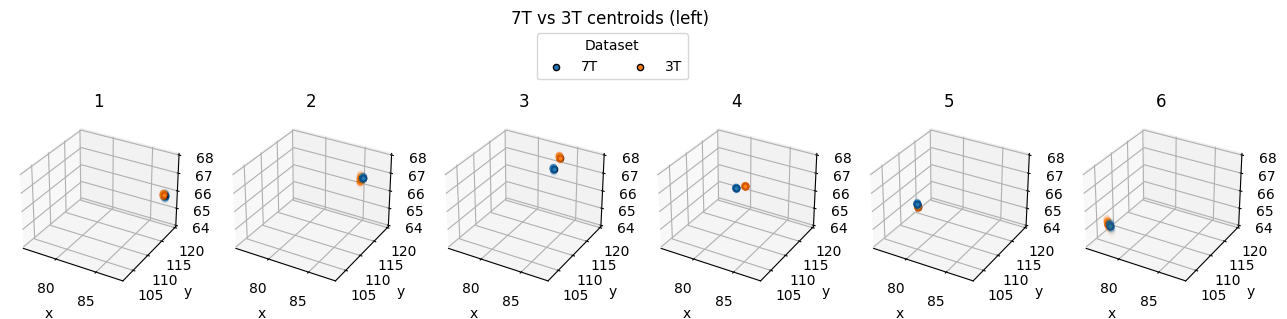

In [ ]:
fig, ax = plt.subplots(
    1,
    6,
    figsize=plt.figaspect(0.25),
    subplot_kw=dict(projection="3d"),
)
fig.suptitle("7T vs 3T centroids (left)")

k = 6
for idx, label in enumerate(range(1, k + 1)):
    for subset in ["7T", "3T"]:
        data_df = (
            hcp_3Tv7T_df.filter(
                (pl.col("subset") == subset)
                & (pl.col("hemi") == "L")
                & (pl.col("label") == label)
            )
            .select("centroid")
            .to_numpy()
        )
        data_x = [row[0][0] for row in data_df]
        data_y = [row[0][1] for row in data_df]
        data_z = [row[0][2] for row in data_df]
        ax[idx].scatter(
            xs=data_x,
            ys=data_y,
            zs=data_z,
            c="#1f77b4" if subset == "7T" else "#ff7f0e",
            edgecolors=None,
            alpha=0.025,
        )
        ax[idx].scatter(
            xs=np.mean(data_x),
            ys=np.mean(data_y),
            zs=np.mean(data_z),
            c="#1f77b4" if subset == "7T" else "#ff7f0e",
            edgecolors="#000000",
            alpha=1,
            label="7T" if subset == "7T" else "3T",
        )

        # Labels
        ax[idx].set_title(label)
        ax[idx].set_xlabel("x")
        ax[idx].set_ylabel("y")
        ax[idx].set_zlabel("z")
        ax[idx].set_xlim([76, 88])
        ax[idx].set_ylim([102, 120])
        ax[idx].set_zlim([64, 68])

# Legend
legend = ax[2].legend(title="Dataset", loc="upper center", ncols=2)
legend.set_bbox_to_anchor((1, 1.5))

plt.savefig("/localscratch/7Tv3T_centroids_left.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

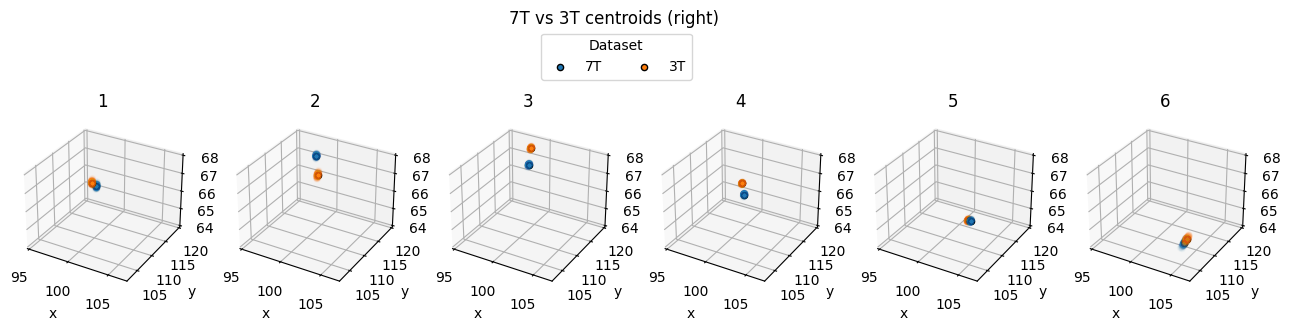

In [ ]:
fig, ax = plt.subplots(
    1,
    6,
    figsize=plt.figaspect(0.25),
    subplot_kw=dict(projection="3d"),
)
fig.suptitle("7T vs 3T centroids (right)")

k = 6
for idx, label in enumerate(range(1, k + 1)):
    for subset in ["7T", "3T"]:
        data_df = (
            hcp_3Tv7T_df.filter(
                (pl.col("subset") == subset)
                & (pl.col("hemi") == "R")
                & (pl.col("label") == label)
            )
            .select("centroid")
            .to_numpy()
        )
        data_x = [row[0][0] for row in data_df]
        data_y = [row[0][1] for row in data_df]
        data_z = [row[0][2] for row in data_df]
        ax[idx].scatter(
            xs=data_x,
            ys=data_y,
            zs=data_z,
            c="#1f77b4" if subset == "7T" else "#ff7f0e",
            edgecolors=None,
            alpha=0.025,
        )
        ax[idx].scatter(
            xs=np.mean(data_x),
            ys=np.mean(data_y),
            zs=np.mean(data_z),
            c="#1f77b4" if subset == "7T" else "#ff7f0e",
            edgecolors="#000000",
            alpha=1,
            label="7T" if subset == "7T" else "3T",
        )

        # Labels
        ax[idx].set_title(label)
        ax[idx].set_xlabel("x")
        ax[idx].set_ylabel("y")
        ax[idx].set_zlabel("z")
        ax[idx].set_xlim([95, 107])
        ax[idx].set_ylim([102, 120])
        ax[idx].set_zlim([64, 68])

# Legend
legend = ax[2].legend(title="Dataset", loc="upper center", ncols=2)
legend.set_bbox_to_anchor((1, 1.5))

plt.savefig("/localscratch/7Tv3T_centroids_right.png", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

#### Template 

##### Distance

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

# Load existing dataframe (should already exist)
if "hcp_3Tv7T_df" not in locals():
    hcp_3Tv7T_df = pl.read_parquet("hcp_3Tv7T_df.parquet")

for subset, hemi in tqdm(
    it.product(
        ("7T", "3T"),
        ("L", "R"),
    ),
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    distances = [[] for _ in range(6)]

    # Load template segmentations
    if hemi == "L":
        template_hemi = "R"
    elif hemi == "R":
        template_hemi = "L"

    dseg = load_dseg_template(subset=subset, hemi=template_hemi)
    template_centroids = get_centroids(dseg)

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):

        # Compute distance
        for idx, centroid in enumerate(template_centroids):
            subject_centroid = (
                hcp_3Tv7T_df.filter(
                    (pl.col("subject") == subject)
                    & (pl.col("subset") == subset)
                    & (pl.col("hemi") == hemi)
                    & (pl.col("label") == (idx + 1))
                )
                .select("centroid")
                .to_numpy()[0][0]
            )
            # dseg = load_dseg(subject=subject, subset=subset, hemi=hemi)
            # subject_centroid = get_centroids(dseg)
            distances[idx].append(np.linalg.norm(np.array(centroid) - subject_centroid))
        clear_output(wait=True)

    # Add distances to dataframe
    for label in range(1, len(template_centroids) + 1):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", [subset] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("distance_to_template", distances[label - 1], dtype=pl.Float32),
        ]
        tmp_df.append(pl.DataFrame(data=data))

tmp_df = pl.concat(tmp_df)
hcp_3Tv7T_df = hcp_3Tv7T_df.join(
    other=tmp_df,
    left_on=["subject", "subset", "hemi", "label"],
    right_on=["subject", "subset", "hemi", "label"],
)

# Save dataframe
hcp_3Tv7T_df.write_parquet("hcp_3Tv7T_df.parquet")

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

# Load existing dataframe (should already exist)
if "hcp_3Tv7T_df" not in locals():
    hcp_3Tv7T_df = pl.read_parquet("hcp_3Tv7T_df.parquet")

for hemi in tqdm(
    ["L", "R"],
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    distances = [[] for _ in range(6)]

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):

        # Compute distance
        for idx in range(len(distances)):
            centroid_7T = (
                hcp_3Tv7T_df.filter(
                    (pl.col("subject") == subject)
                    & (pl.col("subset") == "7T")
                    & (pl.col("hemi") == hemi)
                    & (pl.col("label") == (idx + 1))
                )
                .select("centroid")
                .to_numpy()[0][0]
            )
            centroid_3T = (
                hcp_3Tv7T_df.filter(
                    (pl.col("subject") == subject)
                    & (pl.col("subset") == "3T")
                    & (pl.col("hemi") == hemi)
                    & (pl.col("label") == (idx + 1))
                )
                .select("centroid")
                .to_numpy()[0][0]
            )
            distances[idx].append(np.linalg.norm(centroid_7T - centroid_3T))
        clear_output(wait=True)

    # Add distances to dataframe
    for label in range(1, len(distances) + 1):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", ["7T"] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("distance", distances[label - 1], dtype=pl.Float32),
        ]
        tmp_df.append(pl.DataFrame(data=data))
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", ["3T"] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("distance", distances[label - 1], dtype=pl.Float32),
        ]
        tmp_df.append(pl.DataFrame(data=data))

tmp_df = pl.concat(tmp_df)
hcp_3Tv7T_df = hcp_3Tv7T_df.join(
    other=tmp_df,
    left_on=["subject", "subset", "hemi", "label"],
    right_on=["subject", "subset", "hemi", "label"],
)

# Save dataframe
hcp_3Tv7T_df.write_parquet("hcp_3Tv7T_df.parquet")

##### Dice Similarity

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

for subset, hemi in tqdm(
    it.product(
        ("7T", "3T"),
        ("L", "R"),
    ),
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    dscs = [[] for _ in range(7)]

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        subject_dscs = compute_dsc(
            subject=subject, subset=subset, hemi=hemi, template=True
        )

        for idx, dsc in enumerate(subject_dscs):
            dscs[idx].append(dsc)
        clear_output(wait=True)

    # Add dscs to dataframe
    # Label 0 = overall dice
    for label in range(0, len(dscs)):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", [subset] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("dsc_template", dscs[label], pl.Float32),
        ]
        tmp_df.append(pl.DataFrame(data=data))

tmp_df = pl.concat(tmp_df)
if (df_path := Path(f"{os.getcwd()}/hcp_3Tv7T_df.parquet")).exists():
    hcp_3Tv7T_df = pl.read_parquet(df_path)
    hcp_3Tv7T_df = hcp_3Tv7T_df.join(
        other=tmp_df,
        left_on=["subject", "subset", "hemi", "label"],
        right_on=["subject", "subset", "hemi", "label"],
    )
else:
    hcp_3Tv7T_df = deepcopy(tmp_df)

# Save dataframe
hcp_3Tv7T_df.write_parquet("hcp_3Tv7T_df.parquet")

### Test v Retest

In [ ]:
subjects = get_subject_list("Test")
no_subjects = len(subjects)
print(f"No. of subjects: {len(subjects)}")

No. of subjects: 42


In [ ]:
# Apply transforms to template space
for subset, hemi in tqdm(
    it.product(
        ("Test", "Retest"),
        ("L", "R"),
    ),
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        get_apply_transforms(subject=subject, subset=subset, hemi=hemi)
        clear_output(wait=True)

#### Volume

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

for subset, hemi in tqdm(
    it.product(
        ("Test", "Retest"),
        ("L", "R"),
    ),
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    volumes = [[] for _ in range(6)]

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        dseg = load_dseg(subject=subject, subset=subset, hemi=hemi)
        subject_vols = get_volumes(dseg)

        for idx, vol in enumerate(subject_vols):
            volumes[idx].append(vol)
        clear_output(wait=True)

    # Add volumes to dataframe
    for label in range(1, len(volumes) + 1):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", [subset] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("volume", volumes[label - 1], dtype=pl.Float32),
        ]
        tmp_df.append(pl.DataFrame(data=data))

tmp_df = pl.concat(tmp_df)
if (df_path := Path(f"{os.getcwd()}/hcp_TestvRetest_df.parquet")).exists():
    hcp_TestvRetest_df = pl.read_parquet(df_path)
    hcp_TestvRetest_df = pl.concat([hcp_TestvRetest_df, tmp_df], how="diagonal")
else:
    hcp_TestvRetest_df = deepcopy(tmp_df)

# Save dataframe
hcp_TestvRetest_df.write_parquet("hcp_TestvRetest_df.parquet")

In [ ]:
with pl.Config(tbl_cols=180, set_float_precision=3):
    for kidx in range(1, 7):
        print(f"Label {kidx}")
        print(
            describe_df(
                df=hcp_TestvRetest_df,
                metric="volume",
                group_by=["hemi", "label", "subset"],
                sort_by=["hemi", "subset"],
            )
            .filter(pl.col("label") == kidx)
            .drop("label")
        )

Label 1
shape: (4, 10)
┌──────┬────────┬───────┬─────────┬───────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│ hemi ┆ subset ┆ count ┆ mean    ┆ std   ┆ min     ┆ max     ┆ q25     ┆ median  ┆ q75     │
│ ---  ┆ ---    ┆ ---   ┆ ---     ┆ ---   ┆ ---     ┆ ---     ┆ ---     ┆ ---     ┆ ---     │
│ str  ┆ str    ┆ u32   ┆ f32     ┆ f32   ┆ f32     ┆ f32     ┆ f32     ┆ f32     ┆ f32     │
╞══════╪════════╪═══════╪═════════╪═══════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│ L    ┆ Retest ┆ 42    ┆ 116.000 ┆ 6.711 ┆ 97.300  ┆ 133.000 ┆ 111.300 ┆ 116.200 ┆ 119.700 │
│ L    ┆ Test   ┆ 42    ┆ 136.367 ┆ 6.540 ┆ 119.700 ┆ 147.700 ┆ 133.000 ┆ 137.200 ┆ 140.000 │
│ R    ┆ Retest ┆ 42    ┆ 108.967 ┆ 5.886 ┆ 91.700  ┆ 123.900 ┆ 105.700 ┆ 109.200 ┆ 112.700 │
│ R    ┆ Test   ┆ 42    ┆ 76.167  ┆ 4.974 ┆ 63.700  ┆ 85.400  ┆ 72.800  ┆ 76.300  ┆ 79.800  │
└──────┴────────┴───────┴─────────┴───────┴─────────┴─────────┴─────────┴─────────┴─────────┘
Label 2
shape: (4, 10)
┌──────┬──────

#### Centroids

In [ ]:
hcp_TestvRetest_df = hcp_TestvRetest_df.drop("dsc_right")

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

for subset, hemi in tqdm(
    it.product(
        ("Test", "Retest"),
        ("L", "R"),
    ),
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    centroids = [[] for _ in range(6)]

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        dseg = load_dseg(subject=subject, subset=subset, hemi=hemi)
        subject_centroids = get_centroids(dseg)

        for idx, centroid in enumerate(subject_centroids):
            centroids[idx].append(centroid)
        clear_output(wait=True)

    # Add volumes to dataframe
    for label in range(1, len(centroids) + 1):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", [subset] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("centroid", centroids[label - 1], dtype=pl.List(pl.Float32)),
        ]
        tmp_df.append(pl.DataFrame(data=data))

if "hcp_TestvRetest_df" not in locals():
    hcp_TestvRetest_df = pl.read_parquet("hcp_TestvRetest_df.parquet")
tmp_df = pl.concat(tmp_df)
hcp_TestvRetest_df = hcp_TestvRetest_df.join(
    other=tmp_df,
    left_on=["subject", "subset", "hemi", "label"],
    right_on=["subject", "subset", "hemi", "label"],
)

# Save dataframe
hcp_TestvRetest_df.write_parquet("hcp_TestvRetest_df.parquet")

#### Dice Similarity

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

for hemi in tqdm(
    ("L", "R"),
    position=0,
    leave=False,
    desc="hemi",
    total=2,
    ncols=80,
):
    dscs = [[] for _ in range(7)]

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        subject_dscs = compute_dsc(subject=subject, subset="Test", hemi=hemi)

        for idx, dsc in enumerate(subject_dscs):
            dscs[idx].append(dsc)
        clear_output(wait=True)

    # Add dscs to dataframe
    # Label 0 = overall dice
    for label in range(0, len(dscs)):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", ["Test"] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("dsc", dscs[label], pl.Float32),
        ]
        tmp_df.append(pl.DataFrame(data=data))

tmp_df = pl.concat(tmp_df)
s = pl.Series("subset", ["Retest"] * len(tmp_df), dtype=str)
tmp_df = pl.concat([tmp_df, tmp_df.with_columns(s.alias("subset"))])
if (df_path := Path(f"{os.getcwd()}/hcp_TestvRetest_df.parquet")).exists():
    hcp_TestvRetest_df = pl.read_parquet(df_path)
    hcp_TestvRetest_df = hcp_TestvRetest_df.join(
        tmp_df, on=["subject", "subset", "hemi", "label"], how="inner"
    )
    hcp_TestvRetest_df = pl.concat(
        [hcp_TestvRetest_df, tmp_df.filter(pl.col("label") == 0)], how="diagonal"
    )
else:
    hcp_TestvRetest_df = deepcopy(tmp_df)

# Save dataframe
hcp_TestvRetest_df.write_parquet("hcp_TestvRetest_df.parquet")

In [ ]:
with pl.Config(tbl_cols=180, set_float_precision=3):
    for kidx in range(0, 7):
        print("Overall" if kidx == 0 else f"Label {kidx}")
        print(
            describe_df(
                df=hcp_TestvRetest_df,
                metric="dsc",
                group_by=["hemi", "label", "subset"],
                sort_by=["hemi", "subset"],
            )
            .filter(
                (pl.col("label") == kidx)
                & (pl.col("subset") == "Test")  # Doesn't matter which subset here
            )
            .drop("label")
        )

Overall
shape: (2, 10)
┌──────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬────────┬───────┐
│ hemi ┆ subset ┆ count ┆ mean  ┆ std   ┆ min   ┆ max   ┆ q25   ┆ median ┆ q75   │
│ ---  ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---    ┆ ---   │
│ str  ┆ str    ┆ u32   ┆ f32   ┆ f32   ┆ f32   ┆ f32   ┆ f32   ┆ f32    ┆ f32   │
╞══════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪════════╪═══════╡
│ L    ┆ Test   ┆ 126   ┆ 0.965 ┆ 0.003 ┆ 0.957 ┆ 0.970 ┆ 0.963 ┆ 0.965  ┆ 0.968 │
│ R    ┆ Test   ┆ 126   ┆ 0.922 ┆ 0.005 ┆ 0.914 ┆ 0.933 ┆ 0.918 ┆ 0.923  ┆ 0.926 │
└──────┴────────┴───────┴───────┴───────┴───────┴───────┴───────┴────────┴───────┘
Label 1
shape: (2, 10)
┌──────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬────────┬───────┐
│ hemi ┆ subset ┆ count ┆ mean  ┆ std   ┆ min   ┆ max   ┆ q25   ┆ median ┆ q75   │
│ ---  ┆ ---    ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---   ┆ ---    ┆ ---   │
│ str  ┆ str    ┆ u32   ┆ f32   ┆ f32   ┆

#### Confusion Matrix

In [ ]:
# Initialize dataframe to add data to
confusion_mat = [[], []]

for hidx, hemi in tqdm(
    enumerate(("L", "R")),
    position=0,
    leave=False,
    desc="hemi",
    total=2,
    ncols=80,
):
    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        confusion_mat[hidx].append(
            get_confusion_matrix(
                subject=subject, subset="Test", hemi=hemi, normalize="true"
            )
        )
        clear_output(wait=True)

# Save matrix
np.savez(
    "hcp_TestvRetest_confusion_mats.npz", left=confusion_mat[0], right=confusion_mat[1]
)

# Load to make use of string indexing
confusion_mat = np.load("hcp_TestvRetest_confusion_mats.npz")

#### Figure

In [ ]:
# Load data
hcp_TestvRetest_df = pl.read_parquet("hcp_TestvRetest_df.parquet")

##### Centroid

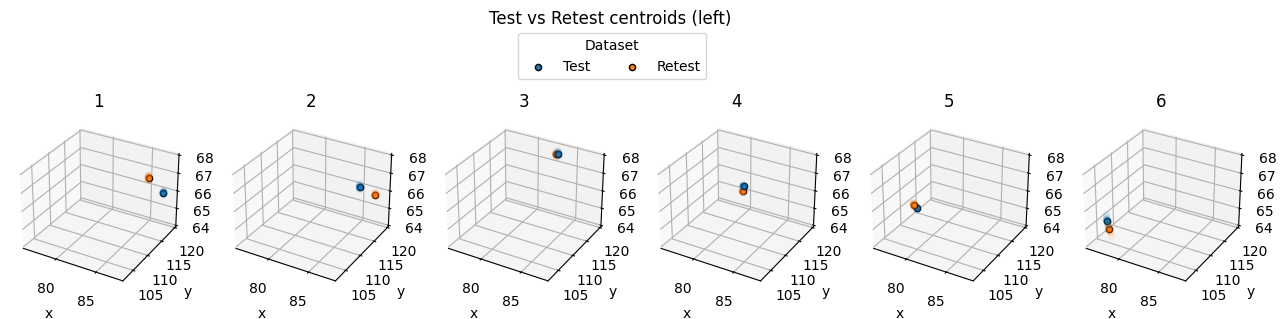

In [ ]:
fig, ax = plt.subplots(
    1,
    6,
    figsize=plt.figaspect(0.25),
    subplot_kw=dict(projection="3d"),
)
fig.suptitle("Test vs Retest centroids (left)")

k = 6
for idx, label in enumerate(range(1, k + 1)):
    for subset in ["Test", "Retest"]:
        data_df = (
            hcp_TestvRetest_df.filter(
                (pl.col("subset") == subset)
                & (pl.col("hemi") == "L")
                & (pl.col("label") == label)
            )
            .select("centroid")
            .to_numpy()
        )
        data_x = [row[0][0] for row in data_df]
        data_y = [row[0][1] for row in data_df]
        data_z = [row[0][2] for row in data_df]
        ax[idx].scatter(
            xs=data_x,
            ys=data_y,
            zs=data_z,
            c="#1f77b4" if subset == "Test" else "#ff7f0e",
            edgecolors=None,
            alpha=0.025,
        )
        ax[idx].scatter(
            xs=np.mean(data_x),
            ys=np.mean(data_y),
            zs=np.mean(data_z),
            c="#1f77b4" if subset == "Test" else "#ff7f0e",
            edgecolors="#000000",
            alpha=1,
            label="Test" if subset == "Test" else "Retest",
        )

        # Labels
        ax[idx].set_title(label)
        ax[idx].set_xlabel("x")
        ax[idx].set_ylabel("y")
        ax[idx].set_zlabel("z")
        ax[idx].set_xlim([76, 88])
        ax[idx].set_ylim([102, 120])
        ax[idx].set_zlim([64, 68])

# Legend
legend = ax[2].legend(title="Dataset", loc="upper center", ncols=2)
legend.set_bbox_to_anchor((1, 1.5))

plt.savefig(
    "/localscratch/TestvRetest_centroids_left.png", dpi=300, bbox_inches="tight"
)
plt.show()
plt.close()

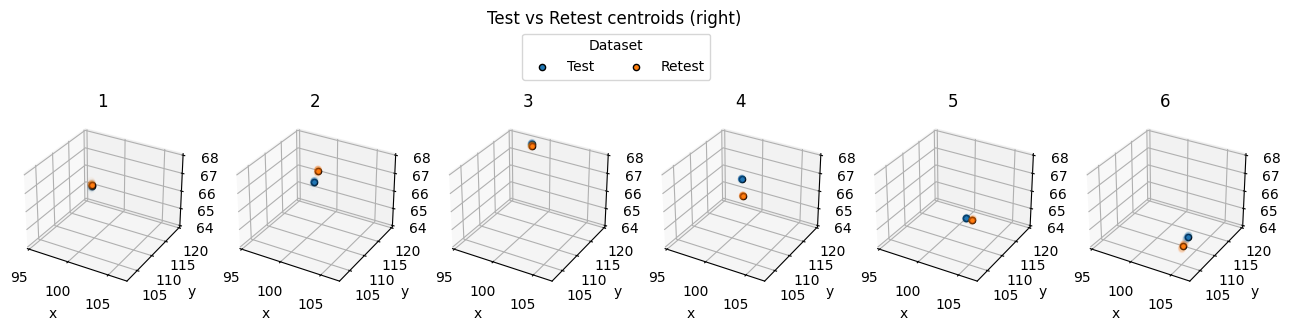

In [ ]:
fig, ax = plt.subplots(
    1,
    6,
    figsize=plt.figaspect(0.25),
    subplot_kw=dict(projection="3d"),
)
fig.suptitle("Test vs Retest centroids (right)")

k = 6
for idx, label in enumerate(range(1, k + 1)):
    for subset in ["Test", "Retest"]:
        data_df = (
            hcp_TestvRetest_df.filter(
                (pl.col("subset") == subset)
                & (pl.col("hemi") == "R")
                & (pl.col("label") == label)
            )
            .select("centroid")
            .to_numpy()
        )
        data_x = [row[0][0] for row in data_df]
        data_y = [row[0][1] for row in data_df]
        data_z = [row[0][2] for row in data_df]
        ax[idx].scatter(
            xs=data_x,
            ys=data_y,
            zs=data_z,
            c="#1f77b4" if subset == "Test" else "#ff7f0e",
            edgecolors=None,
            alpha=0.025,
        )
        ax[idx].scatter(
            xs=np.mean(data_x),
            ys=np.mean(data_y),
            zs=np.mean(data_z),
            c="#1f77b4" if subset == "Test" else "#ff7f0e",
            edgecolors="#000000",
            alpha=1,
            label="Test" if subset == "Test" else "Retest",
        )

        # Labels
        ax[idx].set_title(label)
        ax[idx].set_xlabel("x")
        ax[idx].set_ylabel("y")
        ax[idx].set_zlabel("z")
        ax[idx].set_xlim([95, 107])
        ax[idx].set_ylim([102, 120])
        ax[idx].set_zlim([64, 68])

# Legend
legend = ax[2].legend(title="Dataset", loc="upper center", ncols=2)
legend.set_bbox_to_anchor((1, 1.5))

plt.savefig(
    "/localscratch/TestvRetest_centroids_right.png", dpi=300, bbox_inches="tight"
)
plt.show()
plt.close()

#### Template 

##### Distance

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

# Load existing dataframe (should already exist)
if "hcp_TestvRetest_df" not in locals():
    hcp_TestvRetest_df = pl.read_parquet("hcp_TestvRetest_df.parquet")

for subset, hemi in tqdm(
    it.product(
        ("Test", "Retest"),
        ("L", "R"),
    ),
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    distances = [[] for _ in range(6)]

    # Load template segmentations
    if hemi == "L":
        template_hemi = "R"
    elif hemi == "R":
        template_hemi = "L"

    dseg = load_dseg_template(subset=subset, hemi=template_hemi)
    template_centroids = get_centroids(dseg)

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):

        # Compute distance
        for idx, centroid in enumerate(template_centroids):
            subject_centroid = (
                hcp_TestvRetest_df.filter(
                    (pl.col("subject") == subject)
                    & (pl.col("subset") == subset)
                    & (pl.col("hemi") == hemi)
                    & (pl.col("label") == (idx + 1))
                )
                .select("centroid")
                .to_numpy()[0][0]
            )
            # dseg = load_dseg(subject=subject, subset=subset, hemi=hemi)
            # subject_centroid = get_centroids(dseg)
            distances[idx].append(np.linalg.norm(np.array(centroid) - subject_centroid))
        clear_output(wait=True)

    # Add distances to dataframe
    for label in range(1, len(template_centroids) + 1):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", [subset] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("distance_to_template", distances[label - 1], dtype=pl.Float32),
        ]
        tmp_df.append(pl.DataFrame(data=data))

tmp_df = pl.concat(tmp_df)
hcp_TestvRetest_df = hcp_TestvRetest_df.join(
    other=tmp_df,
    left_on=["subject", "subset", "hemi", "label"],
    right_on=["subject", "subset", "hemi", "label"],
)

# Save dataframe
hcp_TestvRetest_df.write_parquet("hcp_TestvRetest_df.parquet")

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

# Load existing dataframe (should already exist)
if "hcp_TestvRetest_df" not in locals():
    hcp_TestvRetest_df = pl.read_parquet("hcp_TestvRetest_df.parquet")

for hemi in tqdm(
    ["L", "R"],
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    distances = [[] for _ in range(6)]

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):

        # Compute distance
        for idx in range(len(distances)):
            centroid_Test = (
                hcp_TestvRetest_df.filter(
                    (pl.col("subject") == subject)
                    & (pl.col("subset") == "Test")
                    & (pl.col("hemi") == hemi)
                    & (pl.col("label") == (idx + 1))
                )
                .select("centroid")
                .to_numpy()[0][0]
            )
            centroid_Retest = (
                hcp_TestvRetest_df.filter(
                    (pl.col("subject") == subject)
                    & (pl.col("subset") == "Retest")
                    & (pl.col("hemi") == hemi)
                    & (pl.col("label") == (idx + 1))
                )
                .select("centroid")
                .to_numpy()[0][0]
            )
            distances[idx].append(np.linalg.norm(centroid_Test - centroid_Retest))
        clear_output(wait=True)

    # Add distances to dataframe
    for label in range(1, len(distances) + 1):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", ["Test"] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("distance", distances[label - 1], dtype=pl.Float32),
        ]
        tmp_df.append(pl.DataFrame(data=data))
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", ["Retest"] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("distance", distances[label - 1], dtype=pl.Float32),
        ]
        tmp_df.append(pl.DataFrame(data=data))

tmp_df = pl.concat(tmp_df)
hcp_TestvRetest_df = hcp_TestvRetest_df.join(
    other=tmp_df,
    left_on=["subject", "subset", "hemi", "label"],
    right_on=["subject", "subset", "hemi", "label"],
)

# Save dataframe
hcp_TestvRetest_df.write_parquet("hcp_TestvRetest_df.parquet")

##### Dice Similarity

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

for subset, hemi in tqdm(
    it.product(
        ("Test", "Retest"),
        ("L", "R"),
    ),
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    dscs = [[] for _ in range(7)]
    missing_subjects = []

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        # Some subjects missing data
        try:
            subject_dscs = compute_dsc(
                subject=subject, subset=subset, hemi=hemi, template=True
            )

            for idx, dsc in enumerate(subject_dscs):
                dscs[idx].append(dsc)
        except:
            missing_subjects.append(subject)
            for idx, dsc in enumerate(subject_dscs):
                dscs[idx].append(np.nan)
        clear_output(wait=True)

    # Add dscs to dataframe
    # Label 0 = overall dice
    for label in range(0, len(dscs)):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", [subset] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("dsc_template", dscs[label], pl.Float32),
        ]
        tmp_df.append(pl.DataFrame(data=data))

tmp_df = pl.concat(tmp_df)
if (df_path := Path(f"{os.getcwd()}/hcp_TestvRetest_df.parquet")).exists():
    hcp_TestvRetest_df = pl.read_parquet(df_path)
    hcp_TestvRetest_df = hcp_TestvRetest_df.join(
        other=tmp_df,
        left_on=["subject", "subset", "hemi", "label"],
        right_on=["subject", "subset", "hemi", "label"],
    )
else:
    hcp_TestvRetest_df = deepcopy(tmp_df)

# Save dataframe
hcp_TestvRetest_df.write_parquet("hcp_TestvRetest_df.parquet")

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

for subset, hemi in tqdm(
    it.product(
        ("7T"),
        ("L", "R"),
    ),
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    volumes = [[] for _ in range(6)]

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        dseg = load_dseg(subject=subject, subset=subset, hemi=hemi)
        subject_vols = get_volumes(dseg)

        for idx, vol in enumerate(subject_vols):
            volumes[idx].append(vol)
        clear_output(wait=True)

    # Add volumes to dataframe
    for label in range(1, len(volumes) + 1):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", [subset] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("volume", volumes[label - 1], dtype=pl.Float32),
        ]
        tmp_df.append(pl.DataFrame(data=data))

tmp_df = pl.concat(tmp_df)
if (df_path := Path(f"{os.getcwd()}/hcp7T_df.parquet")).exists():
    hcp_7T_df = pl.read_parquet(df_path)
    hcp_7T_df = pl.concat([hcp_7T_df, tmp_df], how="diagonal")
else:
    hcp_7T_df = deepcopy(tmp_df)

# Save dataframe
hcp_7T_df.write_parquet("hcp_7T_df.parquet")

In [ ]:
with pl.Config(tbl_cols=180, set_float_precision=3):
    for kidx in range(1, 7):
        print(f"Label {kidx}")
        print(
            describe_df(
                df=hcp_7T_df,
                metric="volume",
                group_by=["hemi", "label", "subset"],
                sort_by=["hemi", "subset"],
            )
            .filter(pl.col("label") == kidx)
            .drop("label")
        )

#### Centroids

In [ ]:
# Initialize dataframe to add data to
tmp_df = []

for subset, hemi in tqdm(
    it.product(
        ("7T"),
        ("L", "R"),
    ),
    position=0,
    leave=False,
    desc="subset",
    total=4,
    ncols=80,
):
    centroids = [[] for _ in range(6)]

    for subject in tqdm(
        subjects,
        position=1,
        leave=False,
        desc="subject",
        total=no_subjects,
        ncols=80,
    ):
        dseg = load_dseg(subject=subject, subset=subset, hemi=hemi)
        subject_centroids = get_centroids(dseg)

        for idx, centroid in enumerate(subject_centroids):
            centroids[idx].append(centroid)
        clear_output(wait=True)

    # Add volumes to dataframe
    for label in range(1, len(centroids) + 1):
        data = [
            pl.Series("subject", subjects, dtype=str),
            pl.Series("subset", [subset] * no_subjects, dtype=str),
            pl.Series("hemi", [hemi] * no_subjects, dtype=str),
            pl.Series("label", [label] * no_subjects, dtype=pl.Int8),
            pl.Series("centroid", centroids[label - 1], dtype=pl.List(pl.Float32)),
        ]
        tmp_df.append(pl.DataFrame(data=data))

if "hcp_7T_df" not in locals():
    hcp_7T_df = pl.read_parquet("hcp_7T_df.parquet")

tmp_df = pl.concat(tmp_df)
hcp_7T_df = hcp_7T_df.join(
    other=tmp_df,
    left_on=["subject", "subset", "hemi", "label"],
    right_on=["subject", "subset", "hemi", "label"],
)

# Save dataframe
hcp_3Tv7T_df.write_parquet("hcp_7T_df.parquet")

## Installed Packages

_Note: Run this after all used packages have been imported_

In [0]:
import importlib.metadata
import types


def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package not just imported function
            name = val.__name__.split(".")[0]
        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Map imported names to PyPI names
        poorly_named_packages = {"PIL": "Pillow", "sklearn": "scikit-learn"}
        if name in poorly_named_packages:
            name = poorly_named_packages[name]
        yield name


# Get unique imported packages
imports = list(set(get_imports()))

# Cross-check the names of installed packages vs. imported packages
requirements = []
installed_packages = {
    dist.metadata["Name"]: dist.version for dist in importlib.metadata.distributions()
}
for name in imports:
    if name in installed_packages and name != "pip":
        requirements.append((name, installed_packages[name]))

print("Packages used:")
print("==============")
for req_name, req_version in sorted(requirements[::-1], key=lambda x: x[0]):
    print(f"{req_name}=={req_version}")

Packages used:
matplotlib==3.6.2
nibabel==4.0.2
numpy==1.24.4
polars==0.19.19
tqdm==4.65.0
